In [1]:
import numpy as np
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib


In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print (get_available_gpus())


['/device:GPU:0']


In [7]:

# Đường dẫn đến thư mục train và test
train_dir = r'C:\\Users\\duc18\\@MyData\\@Python\\CatBreedsRefined-7K\\CatBreedsRefined-v2_OutputCutter256'
test_dir = r'C:\\Users\\duc18\\@MyData\\@Python\\CatBreedsRefined-7K\\VL_OutputCutter256'

# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator từ thư mục train và test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)


Found 4399 images belonging to 18 classes.
Found 175 images belonging to 18 classes.


In [8]:
# Hiển thị số lượng mẫu trong mỗi lớp cho tập huấn luyện
train_class_counts = np.bincount(train_generator.classes)
for emotion, count in zip(train_generator.class_indices, train_class_counts):
    print(f'Train - {emotion}: {count}')

# Hiển thị số lượng mẫu trong mỗi lớp cho tập kiểm tra
test_class_counts = np.bincount(test_generator.classes)
for emotion, count in zip(test_generator.class_indices, test_class_counts):
    print(f'Test - {emotion}: {count}')

# Hiển thị dạng one-hot của mỗi lớp
for emotion, index in train_generator.class_indices.items():
    one_hot = tf.keras.utils.to_categorical(index, num_classes=len(train_generator.class_indices))
    print(f'{emotion}: {one_hot}')


Train - Abyssinian: 240
Train - American Bobtail: 248
Train - American Curl: 258
Train - American Shorthair: 263
Train - Bengal: 241
Train - Birman: 265
Train - Bombay: 243
Train - British Shorthair: 267
Train - Egyptian Mau: 262
Train - Maine Coon: 274
Train - Norwegian Forest: 267
Train - Persian: 247
Train - Ragdoll: 266
Train - Russian Blue: 268
Train - Scottish Fold: 259
Train - Siamese: 248
Train - Sphynx: 83
Train - Turkish Angora: 200
Test - Abyssinian: 10
Test - American Bobtail: 10
Test - American Curl: 10
Test - American Shorthair: 10
Test - Bengal: 10
Test - Birman: 10
Test - Bombay: 10
Test - British Shorthair: 10
Test - Egyptian Mau: 9
Test - Maine Coon: 10
Test - Norwegian Forest: 11
Test - Persian: 12
Test - Ragdoll: 9
Test - Russian Blue: 10
Test - Scottish Fold: 10
Test - Siamese: 13
Test - Sphynx: 3
Test - Turkish Angora: 8
Abyssinian: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
American Bobtail: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ame

In [9]:
print (train_generator.class_indices)

{'Abyssinian': 0, 'American Bobtail': 1, 'American Curl': 2, 'American Shorthair': 3, 'Bengal': 4, 'Birman': 5, 'Bombay': 6, 'British Shorthair': 7, 'Egyptian Mau': 8, 'Maine Coon': 9, 'Norwegian Forest': 10, 'Persian': 11, 'Ragdoll': 12, 'Russian Blue': 13, 'Scottish Fold': 14, 'Siamese': 15, 'Sphynx': 16, 'Turkish Angora': 17}


In [10]:
def print_data_shape(generator): # oke, ta đã có kích thước cho mỗi traain hoặc test là 48x48x3
    print(f'Data shape: {generator.image_shape}')

print_data_shape(train_generator)
print_data_shape(test_generator)


Data shape: (256, 256, 3)
Data shape: (256, 256, 3)


In [13]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [15]:
input_shape=train_generator.image_shape
print (input_shape)

(256, 256, 3)


In [16]:
# Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(18, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 [==============================] - 2s 0us/step


In [17]:
batch_size = 16
epochs = 300
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
history = model.fit(train_generator,
                    # steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = test_generator, 
                    # validation_steps = test_generator.samples // batch_size,
                    epochs = epochs,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=2)

Epoch 1/300
275/275 - 35s - loss: 1.4841 - accuracy: 0.5331 - val_loss: 1.1269 - val_accuracy: 0.6800 - lr: 5.0000e-04 - 35s/epoch - 127ms/step
Epoch 2/300
275/275 - 22s - loss: 0.7939 - accuracy: 0.7368 - val_loss: 1.1374 - val_accuracy: 0.6857 - lr: 5.0000e-04 - 22s/epoch - 79ms/step
Epoch 3/300
275/275 - 22s - loss: 0.6056 - accuracy: 0.7904 - val_loss: 1.2350 - val_accuracy: 0.7143 - lr: 5.0000e-04 - 22s/epoch - 79ms/step
Epoch 4/300
275/275 - 22s - loss: 0.4575 - accuracy: 0.8472 - val_loss: 1.4636 - val_accuracy: 0.6857 - lr: 5.0000e-04 - 22s/epoch - 79ms/step
Epoch 5/300
275/275 - 22s - loss: 0.3441 - accuracy: 0.8829 - val_loss: 1.5912 - val_accuracy: 0.6400 - lr: 5.0000e-04 - 22s/epoch - 79ms/step
Epoch 6/300
275/275 - 22s - loss: 0.3259 - accuracy: 0.8886 - val_loss: 2.0201 - val_accuracy: 0.6114 - lr: 5.0000e-04 - 22s/epoch - 79ms/step
Epoch 7/300
275/275 - 22s - loss: 0.2536 - accuracy: 0.9177 - val_loss: 1.8128 - val_accuracy: 0.6114 - lr: 5.0000e-04 - 22s/epoch - 80ms/ste

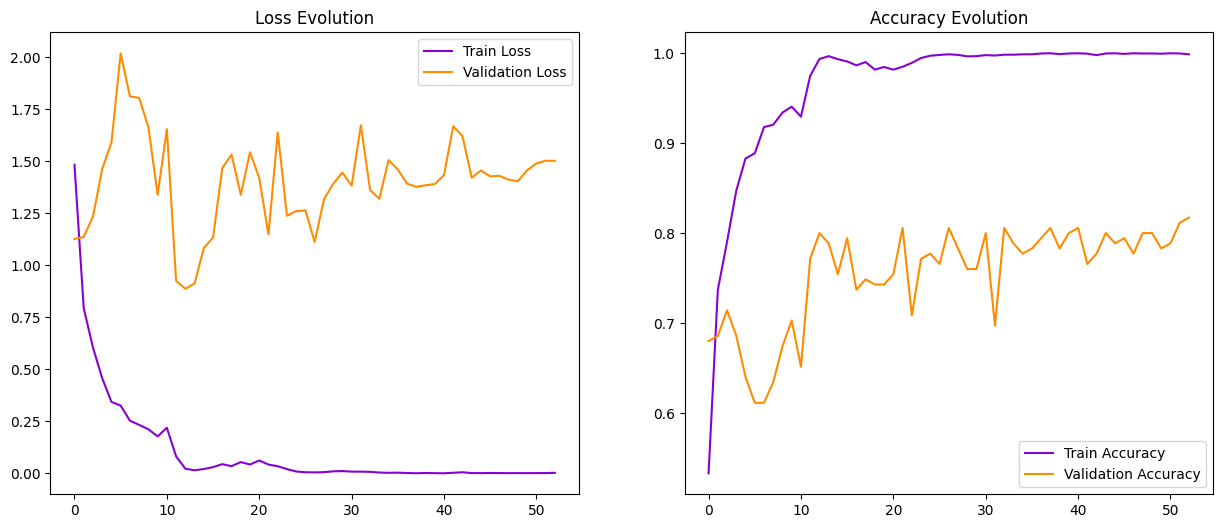

In [18]:

import matplotlib.pyplot as plt
# Plotting the training and validation loss
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()


In [23]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

11/11 [==============================] - 1s 37ms/step - loss: 0.8880 - accuracy: 0.8000

Test Accuracy: 0.800000011920929
Test Loss:     0.8879637122154236


In [21]:
model.save("my_model_Imagenet_2.h5")

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the saved model
model = load_model("my_model_ImageNet_2_BackGroundGT.h5")

# Predict the labels of the test data
test_data, test_labels = next(test_generator)
test_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(model.predict(test_data), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Get the unique labels
labels = sorted(list(set(test_labels)))

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()